In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
print(torch.__version__)


GPU is available
1.5.1


In [2]:
# import images dataset
import os
from PIL import Image
#import cv2


BATCH_SIZE = 32
IMG_SIZE = (300, 300)

#dataset_meta: {img_filename:tags}
#tags:[1,0,0,0,1,...0,1], each index represents a tag, can be found in labels_dict_rev

In [3]:
import json
manifest_path = "./data/safebooru-pic-meta/list.json"
label_path = "./safebooru-labels-dict.json"
model_path = "./safebooru-anime_vgg16.pth"
with open(manifest_path, "r") as fp1:
    dataset_meta=json.load(fp1)
print("dataset size:{}".format(len(dataset_meta)))

with open(label_path,"r") as fp1:
    labels_dict = json.load(fp1)
    labels_dict_rev = {int(labels_dict[k]):k for k in labels_dict}
    print(labels_dict_rev)

dataset size:7151
{0: 'solo', 1: '1girl', 2: 'long_hair', 3: 'smile', 4: 'short_hair', 5: 'looking_at_viewer', 6: 'blush', 7: 'open_mouth', 8: 'breasts', 9: 'blue_eyes', 10: 'blonde_hair', 11: 'skirt', 12: 'brown_hair', 13: 'touhou', 14: 'multiple_girls', 15: 'hat', 16: 'black_hair', 17: 'red_eyes', 18: 'dress', 19: 'simple_background', 20: 'ribbon', 21: 'gloves', 22: 'hair_ornament', 23: 'bangs', 24: 'thigh-highs', 25: 'bow', 26: 'white_background', 27: 'brown_eyes', 28: 'school_uniform', 29: 'twintails', 30: 'original', 31: 'long_sleeves', 32: 'shirt', 33: 'eyebrows_visible_through_hair', 34: 'green_eyes', 35: 'translation_request', 36: 'kantai_collection', 37: 'sitting', 38: 'blue_hair', 39: 'commentary_request', 40: '2girls', 41: 'weapon', 42: 'animal_ears', 43: 'very_long_hair', 44: 'monochrome', 45: 'jewelry', 46: 'absurdres', 47: 'bare_shoulders', 48: '1boy', 49: 'hair_ribbon'}


In [4]:
#load dataset

import random
dataset=[]

classes = {}
labelcounter=0

for fn in dataset_meta:
    tags=np.array(dataset_meta[fn]).astype(np.float32)
    
    img_bytes = Image.open(fn)
    img = torchvision.transforms.functional.resize(img=img_bytes,size=IMG_SIZE)#resize img
    img=(np.array(img)/255.0).astype(np.float32)
    
    if(img.shape != (IMG_SIZE[0],IMG_SIZE[1],3)):
        #skip some black-white image or non-standard rgb image
        continue
    
    dataset.append([img,tags])
    
print("dataset size:{}".format(len(dataset)))     #3670
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size

#remember to shuffle
random.shuffle(dataset)
#doesn't hurt to shuffle again
trainloader = torch.utils.data.DataLoader(dataset[:train_size], shuffle=True, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(dataset[train_size:], shuffle=True, batch_size=BATCH_SIZE)
print("loaded data.")
    

dataset size:7116
loaded data.


rows=5,cols=5


<Figure size 1500x1500 with 0 Axes>

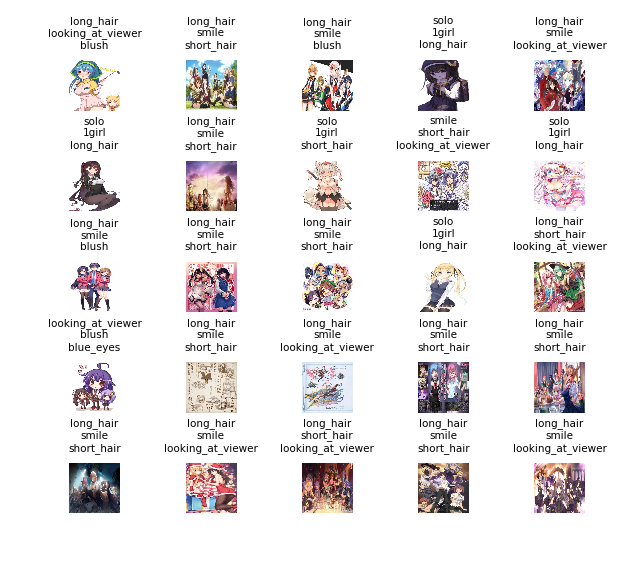

In [5]:
# plot some of the images
import matplotlib.pyplot as plt
import random
import math
import json
import utils
random.seed(2333)

classes = labels_dict        #just alias
classes_rev = labels_dict_rev

subset = random.sample(dataset,25)
utils.show_imgs_multi_label(data=[item[0] for item in subset],real_labels=[item[1] for item in subset],classes_rev=classes_rev,dispMax=3)


In [6]:
import torchvision.models as models
from torchsummary import summary
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
    #print(param)
    param.requires_grad = False

vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=len(classes))
# vgg16.classifier. torch.nn.Softmax
print(vgg16)

#vgg16.cuda()    #move it to cuda
#summary(vgg16, (3, 300, 300))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
#take a look of example input-output of mdel
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    # torch.max[0] stores the data, torch.max[1] stores the index (of the max)
    tag_len = list(target[0].size())[0]#would be 50 tags in current setting
    #     print("val:{}".format(    torch.sum((logit==target) * (target==True))    ))#if we only want precision use this
    corrects = torch.sum((torch.gt(logit,0.5)==torch.gt(target,0.5)))   #number of true pos + number of true neg
    #corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/(batch_size*tag_len)
    #print("correct guess:{}, total num:{},acc:{}".format(corrects, batch_size*tag_len, accuracy))
    return accuracy.item()

for images, labels in trainloader:
    b = images.permute(0,3,1,2)#rearrange shape
    print(b.shape)
    print(labels.shape)
    out = vgg16(b)
    print("batch size:", images.shape)
    print(out.shape)
    acc = get_accuracy(out,labels,BATCH_SIZE)
    
    #out[i] is array[5] with probability; labels[i] is ground truth
    #use max of out[i] as prediction
    #print("{},{}".format(out[0],labels[0]))
    break
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return
# for images, labels in trainloader:
#     pass
# for images, labels in testloader:
#     pass
print("ok")

torch.Size([32, 3, 300, 300])
torch.Size([32, 50])
batch size: torch.Size([32, 300, 300, 3])
torch.Size([32, 50])
ok


In [8]:
#start training
import torch.optim as optim

learning_rate = 0.01
num_epochs=20

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(vgg16.classifier[-1].parameters(),lr=learning_rate,momentum=0.9)

torch.cuda.empty_cache()

In [9]:
res=[]
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    vgg16 = vgg16.train()
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        b = images.permute(0,3,1,2)
        out = vgg16(b)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        del b
        del images
        ## update model params
        optimizer.step()
        train_running_loss += loss.detach().item()      #make a copy without tracking it
        train_acc += get_accuracy(out, labels, BATCH_SIZE)#use += instead of =
        del labels
        del loss
    vgg16.eval()
    test_acc = 0.0
    if(True):
        for j, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            b = images.permute(0,3,1,2)
            outputs = vgg16(b)
            test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
            del images
            del labels
            del b

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f' \
              %(epoch, train_running_loss / i, train_acc/i, test_acc/j ))#accumulated, so use += before
        res.append([learning_rate, epoch, train_running_loss / i, train_acc/i, test_acc/j])

freeze_model(vgg16)#freeze the model

cuda:0
Epoch: 0 | Loss: 0.5764 | Train Accuracy: 67.69 | Test Accuracy: 69.83
Epoch: 1 | Loss: 0.5474 | Train Accuracy: 70.00 | Test Accuracy: 70.81
Epoch: 2 | Loss: 0.5404 | Train Accuracy: 70.53 | Test Accuracy: 70.98
Epoch: 3 | Loss: 0.5362 | Train Accuracy: 71.01 | Test Accuracy: 71.13
Epoch: 4 | Loss: 0.5333 | Train Accuracy: 71.09 | Test Accuracy: 71.67


KeyboardInterrupt: 

model saved to ./safebooru-anime_vgg16.pth
torch.Size([25, 3, 300, 300])
correct prediction for image[0]:34/50
correct prediction for image[1]:40/50
correct prediction for image[2]:36/50
correct prediction for image[3]:42/50
correct prediction for image[4]:31/50
correct prediction for image[5]:31/50
correct prediction for image[6]:31/50
correct prediction for image[7]:33/50
correct prediction for image[8]:37/50
correct prediction for image[9]:31/50
correct prediction for image[10]:41/50
correct prediction for image[11]:34/50
correct prediction for image[12]:37/50
correct prediction for image[13]:36/50
correct prediction for image[14]:32/50
correct prediction for image[15]:35/50
correct prediction for image[16]:36/50
correct prediction for image[17]:42/50
correct prediction for image[18]:36/50
correct prediction for image[19]:30/50
correct prediction for image[20]:41/50
correct prediction for image[21]:37/50
correct prediction for image[22]:41/50
correct prediction for image[23]:38/50
c

<Figure size 1500x1500 with 0 Axes>

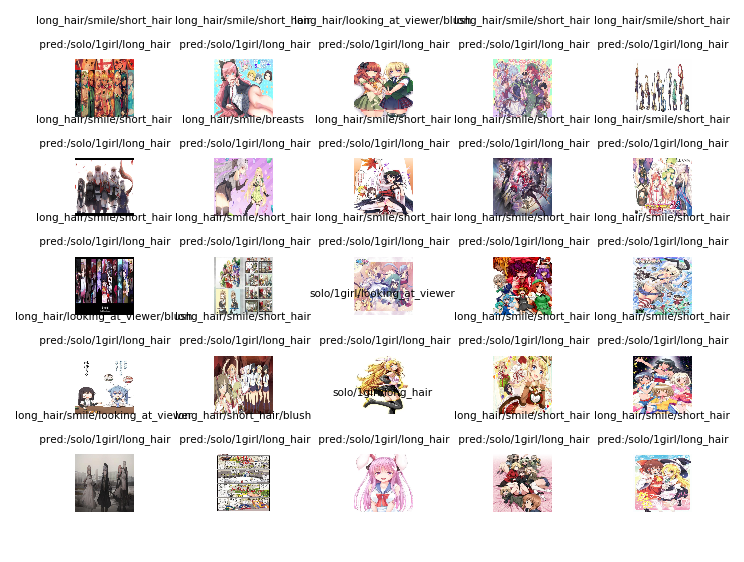

In [17]:
import importlib
importlib.reload(utils)

torch.save(vgg16, model_path)
print("model saved to {}".format(model_path))
subset = random.sample(dataset,25)
imgs = np.asarray([item[0] for item in subset])
    #subset=np.append(subset,item[0])
imgs = torch.tensor(imgs)
imgs = imgs.to(device)
b = imgs.permute(0,3,1,2)

print(b.shape)
outputs = vgg16(b)

corrects = torch.gt(outputs,0.5).data
correct_num=0
for i in range(25):
    correct_num=0
    true_labels=subset[i][1]
    for j in range(len(true_labels)):
        if(corrects[i][j] == true_labels[j]):
            correct_num+=1
    print("correct prediction for image[{}]:{}/{}".format(i,correct_num,len(subset[i][1])))

utils.show_imgs_multi_label(data=[item[0] for item in subset],real_labels=[item[1] for item in subset],pred_labels=corrects,classes_rev=classes_rev,dispMax=3)

#utils.show_imgs(data=[item[0] for item in subset],real_labels=[item[1] for item in subset],pred_labels=None,classes_rev=classes_rev)